<a href="https://colab.research.google.com/github/siva-ganesh-guduru/Astronomical-Image-Classification-using-Machine-Learning/blob/main/FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install astroML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
%matplotlib inline
# Brute force direct downloads source and noise images to circumvent size limitations
# for google drive internal virus scan. Download may take some time.

import os
import requests

files = {'sources': (os.path.join('data', 'stamps_noise.npy'), '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ'),
         'noise': (os.path.join('data', 'stamps_sources.npy'), '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc')}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")

        os.makedirs(os.path.dirname(name), exist_ok=True)
        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content)
    print(f"File {name} is downloaded")

sources = np.load(files['sources'][0])
noise = np.load(files['noise'][0])

File data/stamps_noise.npy is downloaded
File data/stamps_sources.npy is downloaded


In [ ]:
np.set_printoptions(precision=2)

def normalize_image(image):
    '''Rescale the constrast in an image based on the noise (used for displays and the CNN)'''
    sigmaG_coeff =  0.7413
    image = image.reshape(21,21)

    per25,per50,per75 = np.percentile(image,[25,50,75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # sigma clip image, remove background, and normalize to unity
    image[image<(per50-2*sigmaG)] = per50-2*sigmaG
    image -= np.min(image)
    image /= np.sum(image)

    return image

def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='', subtitle=False,
                     class_true=None, classes=None):
    '''Plot an array of images'''
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows*ncols):
        i = int(indx/ncols)
        j = indx%ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx,ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' %
              (np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx,1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

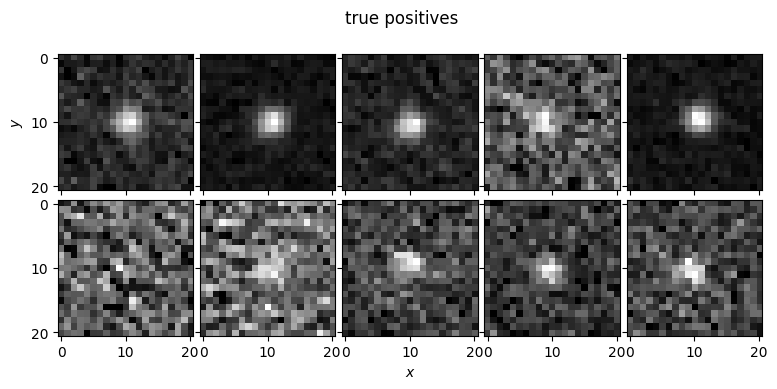

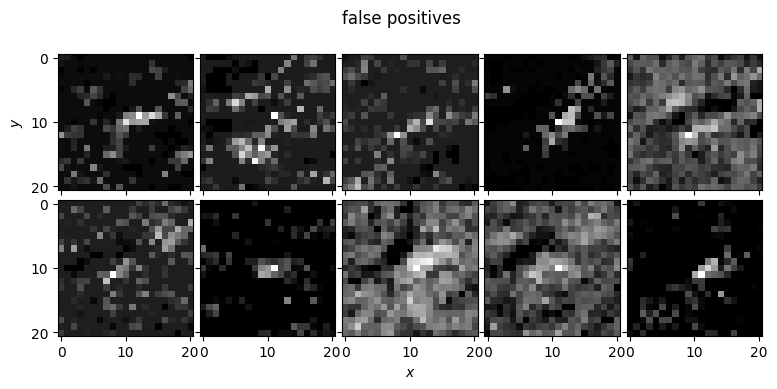

In [ ]:
# normalizing images

point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))

no_point_source_stamps = []
for image in noise:
    no_point_source_stamps.append(normalize_image(image))
# plot sample of images
plot_image_array(no_point_source_stamps, title='true positives')
plot_image_array(point_source_stamps, title='false positives')

In [ ]:
from tensorflow.keras.utils import to_categorical
def reshape_arrays(data, labels):
    '''reshape arrays for Keras'''
    data = data.reshape(-1,21, 21, 1)
    labels = to_categorical(labels)
    return data,labels

# combine the false positives and true positives
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 for noise, 1 for a star

# split the samples into training, validation and test data sets
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class,
                                                                                        [0.7,0.1,0.2])
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('Number of samples in the training ({}); test ({}); and validation ({}) data sets'.format(data_train.shape[0],
                                                                                    data_test.shape[0],
                                                                                   data_val.shape[0]))

Number of samples in the training (76666); test (21905); and validation (10952) data sets


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
# Assuming you have reshaped data_train and data_test
# Assuming class_train and class_test are the corresponding labels (multi-label)

# Flatten the 3D images to 1D arrays
data_train_flattened = data_train.reshape(data_train.shape[0], -1)
data_test_flattened = data_test.reshape(data_test.shape[0], -1)

# Create a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values for 'n_neighbors'

# Fit the KNN classifier on the training data
knn_classifier.fit(data_train_flattened, class_train)

# Make predictions on the test set
predicted_values = knn_classifier.predict(data_test_flattened)

accuracy = accuracy_score(class_test, predicted_values)

classification_rep = classification_report(class_test, predicted_values)

# Print the results
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_rep)


Accuracy: 0.8213649851632048
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.85     11999
           1       0.85      0.74      0.79      9906

   micro avg       0.82      0.82      0.82     21905
   macro avg       0.83      0.81      0.82     21905
weighted avg       0.82      0.82      0.82     21905
 samples avg       0.82      0.82      0.82     21905



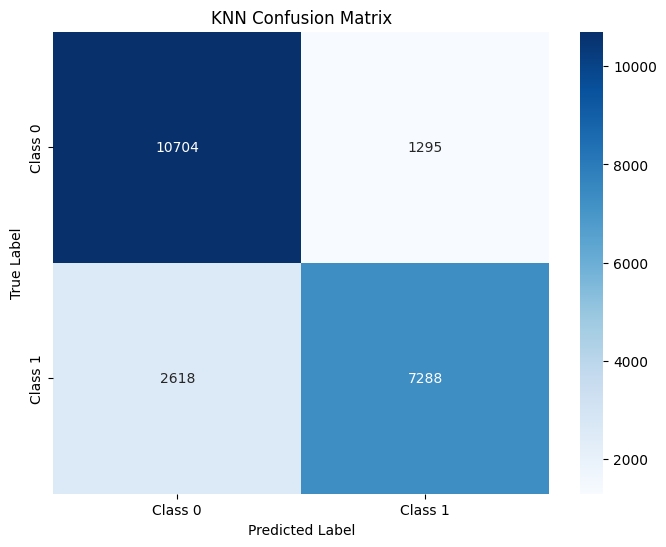

KNN Confusion Matrix:
[[10704  1295]
 [ 2618  7288]]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming class_test is in one-hot encoded format
class_test_1d = np.argmax(class_test, axis=1)

# Use the classifier's predict method
predictions = knn_classifier.predict(data_test_flattened)

# Ensure predictions are in the correct format for binary classification
predictions_binary = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm_knn = confusion_matrix(class_test_1d, predictions_binary)



# Plot the confusion matrix for KNN using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display the confusion matrix values for KNN
print("KNN Confusion Matrix:")
print(cm_knn)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming you have reshaped data_train and data_test
# Assuming class_train and class_test are the corresponding labels (0 for noise, 1 for a star)

# Flatten the 3D images to 1D arrays
data_train_flattened = data_train.reshape(data_train.shape[0], -1)
data_test_flattened = data_test.reshape(data_test.shape[0], -1)

class_train_1d = class_train.argmax(axis=1)
class_test_1d = class_test.argmax(axis=1)

# Create an LDA classifier
lda_classifier = LinearDiscriminantAnalysis()

# Fit the LDA classifier on the training data
lda_classifier.fit(data_train_flattened, class_train_1d)

# Make predictions on the test set
predictions_lda = lda_classifier.predict(data_test_flattened)

# Evaluate the performance using LDA
accuracy_lda = accuracy_score(class_test_1d, predictions_lda)
classification_rep_lda = classification_report(class_test_1d, predictions_lda)

# Print the results for LDA
print("LDA Accuracy:", accuracy_lda)
print("LDA Classification Report:\n", classification_rep_lda)


LDA Accuracy: 0.8901164117781328
LDA Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90     11999
           1       0.87      0.89      0.88      9906

    accuracy                           0.89     21905
   macro avg       0.89      0.89      0.89     21905
weighted avg       0.89      0.89      0.89     21905



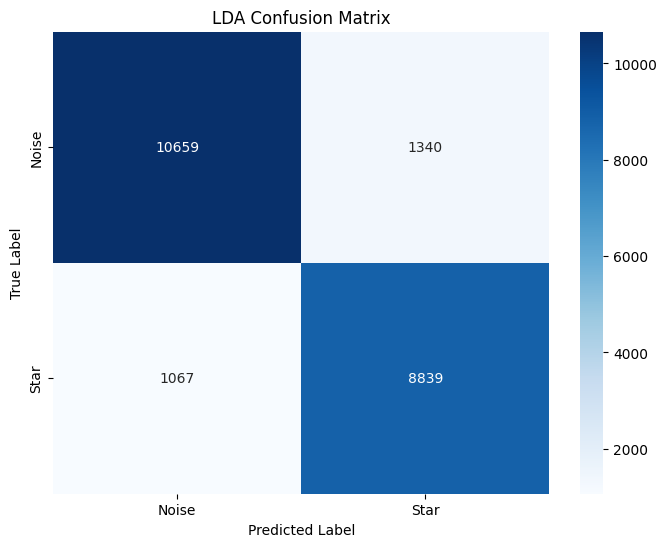

LDA Confusion Matrix:
[[10659  1340]
 [ 1067  8839]]


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix for LDA
cm_lda = confusion_matrix(class_test_1d, predictions_lda)

# Plot the confusion matrix for LDA using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Blues", xticklabels=['Noise', 'Star'], yticklabels=['Noise', 'Star'])
plt.title('LDA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display the confusion matrix values for LDA
print("LDA Confusion Matrix:")
print(cm_lda)


In [ ]:
# Create a QDA classifier
qda_classifier = QuadraticDiscriminantAnalysis()

# Fit the QDA classifier on the training data
qda_classifier.fit(data_train_flattened, class_train_1d)

# Make predictions on the test set
predictions_qda = qda_classifier.predict(data_test_flattened)

# Evaluate the performance using QDA
accuracy_qda = accuracy_score(class_test_1d, predictions_qda)
classification_rep_qda = classification_report(class_test_1d, predictions_qda)

# Print the results for QDA
print("QDA Accuracy:", accuracy_qda)
print("QDA Classification Report:\n", classification_rep_qda)


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Accuracy: 0.6872860077607852
QDA Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78     11999
           1       1.00      0.31      0.47      9906

    accuracy                           0.69     21905
   macro avg       0.82      0.65      0.62     21905
weighted avg       0.80      0.69      0.64     21905



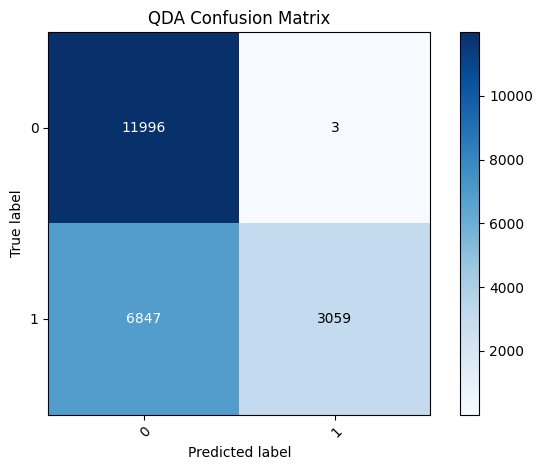

QDA Confusion Matrix:
[[11996     3]
 [ 6847  3059]]


In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix for QDA
cm_qda = confusion_matrix(class_test_1d, predictions_qda)

# Plot the confusion matrix for QDA
plot_confusion_matrix(class_test_1d, predictions_qda, title='QDA Confusion Matrix', cmap=plt.cm.Blues)
plt.show()

# Display the confusion matrix values for QDA
print("QDA Confusion Matrix:")
print(cm_qda)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report
# Assuming you have defined the reshape_arrays function and loaded your data

# Define input shape and number of classes
input_shape = (21, 21, 1)
num_classes = 2  # Binary classification (0 for noise, 1 for star)

# Define a simplified YOLO-like architecture
def yolo_like_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))  # Using sigmoid for binary classification

    return model

# Create the YOLO-like model
model = yolo_like_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Train the model
model.fit(data_train, class_train, epochs=10)  # Assuming data_train is not flattened

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(data_test, class_test)  # Assuming data_test is not flattened
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Evaluate the model on the test set
predictions = model.predict(data_test)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions)

# Classification report
report = classification_report(class_test, predicted_labels)
print("Classification Report:\n", report)


Epoch 1/10
2396/2396 [==============================] - 38s 15ms/step - loss: 0.1473 - accuracy: 0.9357
Epoch 2/10
2396/2396 [==============================] - 37s 16ms/step - loss: 0.0554 - accuracy: 0.9789
Epoch 3/10
2396/2396 [==============================] - 37s 15ms/step - loss: 0.0492 - accuracy: 0.9816
Epoch 4/10
2396/2396 [==============================] - 36s 15ms/step - loss: 0.0441 - accuracy: 0.9835
Epoch 5/10
2396/2396 [==============================] - 36s 15ms/step - loss: 0.0420 - accuracy: 0.9841
Epoch 6/10
2396/2396 [==============================] - 40s 17ms/step - loss: 0.0412 - accuracy: 0.9846
Epoch 7/10
2396/2396 [==============================] - 41s 17ms/step - loss: 0.0390 - accuracy: 0.9858
Epoch 8/10
2396/2396 [==============================] - 40s 17ms/step - loss: 0.0377 - accuracy: 0.9861
Epoch 9/10
2396/2396 [==============================] - 35s 15ms/step - loss: 0.0368 - accuracy: 0.9863
Epoch 10/10
685/685 [==============================] - 4s 5ms/st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


685/685 [==============================] - 3s 5ms/step
Combined Confusion Matrix:
 [[21599   306]
 [  312 21593]]


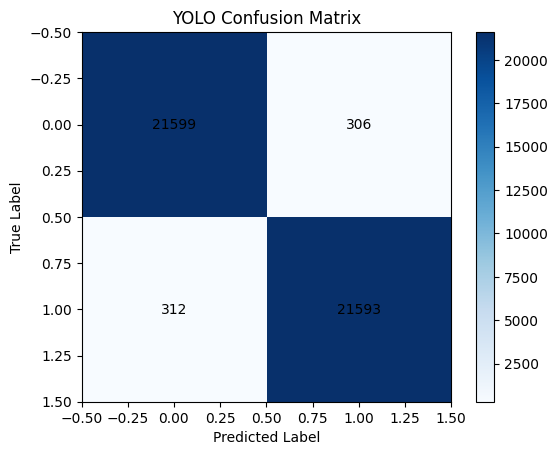

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

predictions = model.predict(data_test)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions)

# Compute multilabel confusion matrix
cm = multilabel_confusion_matrix(class_test, predicted_labels)

# Combine the confusion matrices for both classes
combined_cm = np.sum(cm, axis=0)
print("Combined Confusion Matrix:\n", combined_cm)
# Display the combined confusion matrix with numerical values
plt.imshow(combined_cm, cmap='Blues', interpolation='None')

# Display numerical values in each cell
for i in range(combined_cm.shape[0]):
    for j in range(combined_cm.shape[1]):
        plt.text(j, i, str(combined_cm[i, j]), ha='center', va='center', color='black')

plt.title('YOLO Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()


In [ ]:
pip install pytorch-lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense (fully connected) layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))  # Assuming 2 classes (0 for noise, 1 for a star)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Specify the input shape based on your data
input_shape = (21, 21, 1)

# Create the CNN model
cnn_model = create_cnn_model(input_shape)

# Display the model summary
cnn_model.summary()

# Train the model
history = cnn_model.fit(data_train, class_train, epochs=10, validation_data=(data_val, class_val))

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(data_test, class_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 19, 19, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 64)               

685/685 [==============================] - 4s 5ms/step


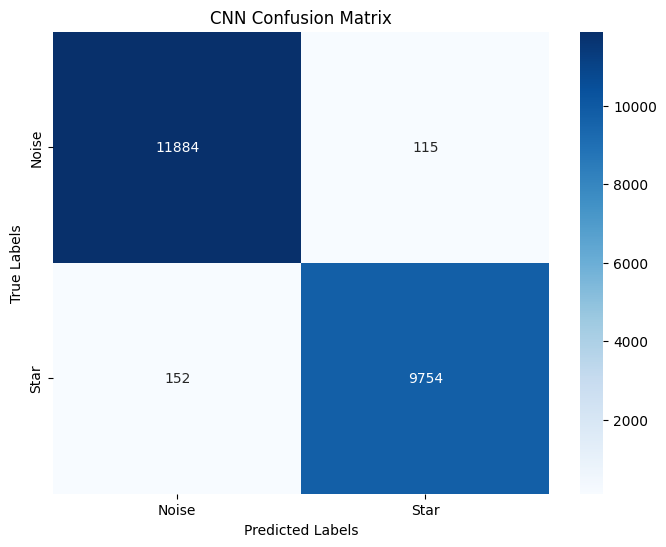

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11999
           1       0.99      0.98      0.99      9906

    accuracy                           0.99     21905
   macro avg       0.99      0.99      0.99     21905
weighted avg       0.99      0.99      0.99     21905



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Convert the predicted probabilities to class labels
y_pred = np.argmax(cnn_model.predict(data_test), axis=1)

# Convert one-hot encoded class_test back to integer labels
y_true = np.argmax(class_test, axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'Star'], yticklabels=['Noise', 'Star'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))


685/685 [==============================] - 3s 5ms/step


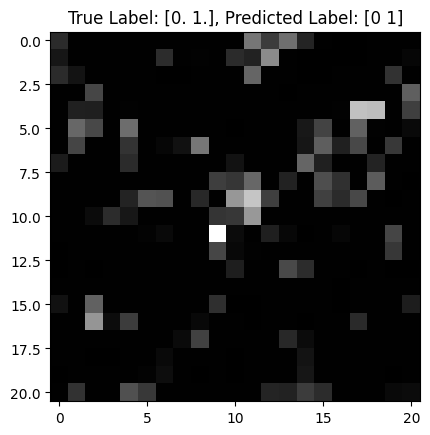

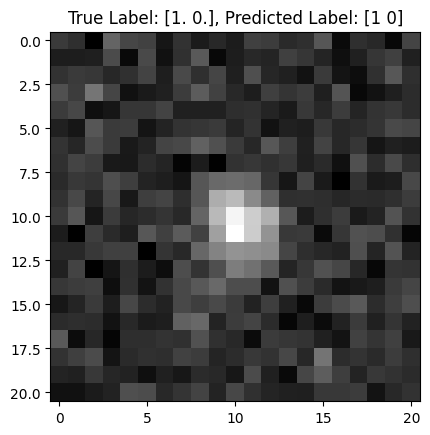

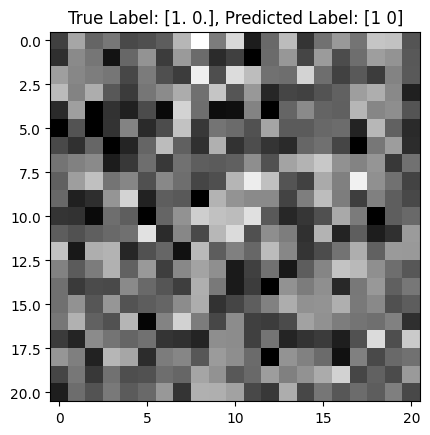

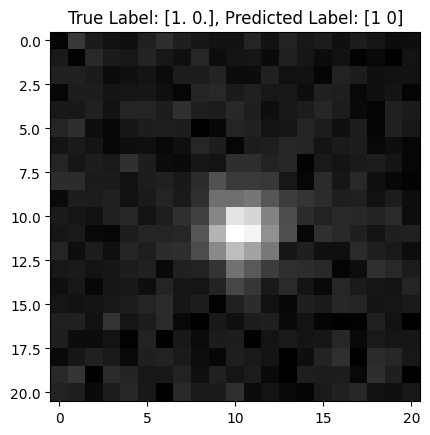

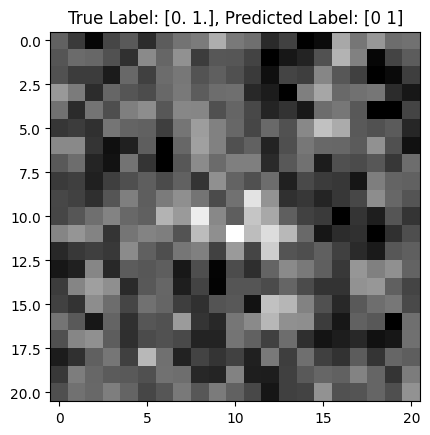

In [ ]:
import matplotlib.pyplot as plt
import random

# Assuming you have the original images stored in a variable called data_test
# and the true labels for the test set in class_test

# Get the predicted labels from the model
predicted_labels = model.predict(data_test)

# Extract the predicted class (assuming it's a binary classification)
predicted_classes = (predicted_labels > 0.5).astype(int)

# Visualize a random sample of test images along with true and predicted labels
num_samples = 5
random_indices = random.sample(range(len(data_test)), num_samples)

for idx in random_indices:
    # Original image
    original_image = data_test[idx].reshape(input_shape)

    # True label
    true_label = class_test[idx]

    # Predicted label
    predicted_label = predicted_classes[idx]

    # Display the image along with true and predicted labels
    plt.imshow(original_image[:, :, 0], cmap='gray')  # Assuming the image is grayscale
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()
